[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/image-understanding-2022-2023/blob/main/practice3/practice3.ipynb)

Fill with your data:

- Full name 1: 
- Full name 2: 

# Image classification

In this practice, you will learn how to build an image classifier using PyTorch in Google Colab. You will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes. The goal is to train a neural network to correctly classify the images into their respective classes.

### Step 1: Set up Google Colab

Make sure to select "GPU" as the runtime type. For this you need to click on the menu Runtime/Change Runtime Type and select GPU.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# assert device.type == 'cuda', 'GPU is not selected.'

Device: cpu


In [2]:
def set_seed(seed):
    # Function to ensure the reproducibility of the results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

### Step 2: Load the CIFAR-10 dataset

Next, you will load the CIFAR-10 dataset using PyTorch's built-in datasets module. You will also split the dataset into training and validation sets.

In [3]:
set_seed(0)
batch_size = 10

# Define the transforms to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Split the training set into training and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])


# Initialize the data loader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:09<00:00, 18122886.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


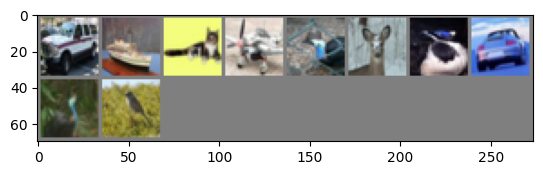

car   ship  cat   plane bird  deer  bird  car   bird  bird 


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step 3: Define the neural network

Next, you will define the neural network using PyTorch's nn module. You can choose any architecture you like, but for simplicity, we will use a basic convolutional neural network (CNN).

In [5]:
set_seed(0)

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, 
                               stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, 
                               stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, 
                               stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, 
                               stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)
        return output

# Instantiate a neural network model 
model = Network()

### Step 4: Train the neural network

Now you will train the neural network using stochastic gradient descent (SGD) with a learning rate of 0.001 and a batch size of 32.

In [6]:
set_seed(0)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs = 10

train_loss = []
valid_loss = []

# Train the network
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    for i, data in pbar:
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_description(
                f'Train Loss: {loss.item():.6f},  epoch: {epoch}/{num_epochs}')
    train_loss.append(running_loss / len(trainloader))

    model.eval()
    pbar = tqdm(enumerate(validloader, 0), total=len(validloader))
    running_val_loss = 0.0
    with torch.no_grad():
        for i, data in pbar:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            pbar.set_description(
                f'Validation Loss: {loss.item():.6f},  epoch: {epoch}/{num_epochs}')
        valid_loss.append(running_val_loss / len(validloader))

Validation Loss: 1.398061,  epoch: 9/10: 100%|██████████| 1000/1000 [00:16<00:00, 60.28it/s]


In [7]:
#### Saving pretrained model
torch.save(model.state_dict(), 'pretrained_model_1.ckpt')

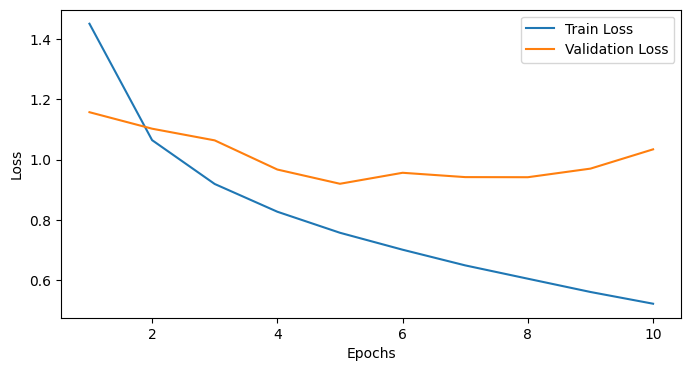

In [8]:
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 5: Evaluate the neural network

Finally, you will evaluate the performance of the neural network on the test set.

In [9]:
### Loading the pretrained model if exists
if os.path.exists('pretrained_model1_.ckpt'):
    model.load_state_dict(torch.load('pretrained_model_1.ckpt'))

In [10]:
# Evaluate the network on the validation set
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

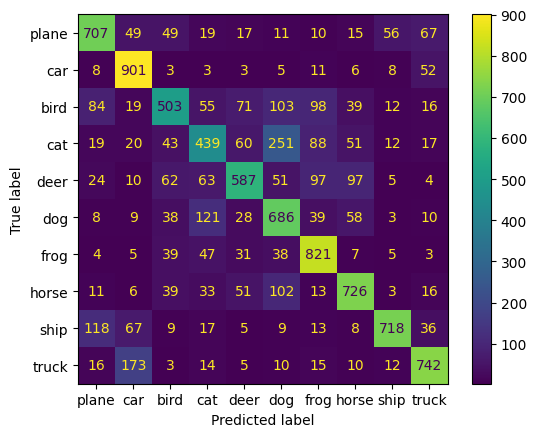

In [11]:
confusion_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, 
                              display_labels=classes)
disp.plot()
plt.show()

In [96]:
def accuracy_np(predictions: np.ndarray, targets: np.ndarray) -> float:
    """
    Calculates the accuracy of predicted labels given the actual labels, using NumPy.

    Args:
      predictions: an array of predicted labels (shape: N)
      targets: an array of actual labels (shape: N)

    Returns:
      accuracy: the accuracy of the predictions (scalar)
    """
    positives = len([x for x, y in zip(predictions, targets) if x == y])
    negatives = len([x for x, y in zip(predictions, targets) if x != y])
    return positives / (positives + negatives)

In [97]:
assert accuracy_np([1, 1, 1, 1], [1, 1, 1, 1]) == 1.0
assert accuracy_np([1, 1, 1, 0], [1, 1, 1, 1]) == 0.75

In [87]:
def recall_np(predictions: np.ndarray, targets: np.ndarray, class_id: int) -> float:
    """
    Calculates the recall of a given class given the predicted labels and actual labels, using NumPy.

    Args:
      predictions: an array of predicted labels (shape: N)
      targets: an array of actual labels (shape: N)
      class_id: the ID of the class to calculate recall for

    Returns:
      recall: the recall of the specified class (scalar), 
      if the divisor is 0, the result should be 0.
    """ 
    true_positives = len([x for x, y in zip(predictions, targets) if x == class_id and y == class_id])
    false_positives = len([x for x, y in zip(predictions, targets) if x != class_id and y == class_id ])
    if true_positives + false_positives == 0:
        return 0 
    return np.clip(true_positives / (true_positives + false_positives), 0, 1)

In [88]:
assert recall_np([1, 2, 1, 1], [1, 1, 2, 1], 0) == 0
assert recall_np([1, 1, 1, 1], [1, 1, 2, 1], 1) == 1.0

0 0
3 0


In [89]:
def precision_np(predictions: np.ndarray, targets: np.ndarray, class_id: int):
    """
    Calculates the precision of a given class given the predicted labels and actual labels, using NumPy.

    Args:
      predictions: an array of predicted labels (shape: N)
      targets: an array of actual labels (shape: N)
      class_id: the ID of the class to calculate precision for

    Returns:
      precision: the precision of the specified class (scalar),
      if the divisor is 0, the result should be 0.
    """
    true_positives = len([x for x, y in zip(predictions, targets) if x == class_id and y == class_id and y == x])
    false_positives = len([x for x, y in zip(predictions, targets) if x == class_id and y != class_id and y != x])
    return true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0

In [78]:
assert precision_np([1, 2, 1, 1], [1, 1, 2, 1], 0) == 0
assert precision_np([1, 1, 1, 1], [1, 1, 2, 1], 1) == 0.75

In [98]:
print(f'Accuracy_ {accuracy_np(y_pred, y_true)}')

Accuracy_ 0.683


In [99]:
print('Recall per class:')
for i in range(len(classes)):
    print(f'{classes[i]}: {recall_np(y_pred, y_true, i)}')

Recall per class:
707 293
plane: 0.707
901 99
car: 0.901
503 497
bird: 0.503
439 561
cat: 0.439
587 413
deer: 0.587
686 314
dog: 0.686
821 179
frog: 0.821
726 274
horse: 0.726
718 282
ship: 0.718
742 258
truck: 0.742


In [100]:
print('Precision per class:')
for i in range(len(classes)):
    print(f'{classes[i]}: {precision_np(y_pred, y_true, i)}')

Precision per class:
plane: 0.7077077077077077
car: 0.715647339158062
bird: 0.6383248730964467
cat: 0.5413070283600493
deer: 0.6841491841491841
dog: 0.5418641390205371
frog: 0.6813278008298755
horse: 0.7138643067846607
ship: 0.8609112709832134
truck: 0.770508826583593


# Image classification with Data Augmentation

### Step 6: Define the transformations
We can easily add more images dding some transformations to the images. In particular, we added:
- RandomHorizontalFlip: randomly flips the image thorugh the horizontal axis
- ColorJitter: randomly adjusts brightness, contrast, saturation, and hue of the image.
- GaussianBlur: applies Gaussian blur with a given kernel size and standard deviation.

In [101]:
set_seed(0)
batch_size = 10

# Define the transforms to be applied to the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.1, contrast=0.1, 
                           saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, 
                            sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Split the training set into training and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])


# Initialize the data loader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Step 7: Instantiate an new model

In [102]:
set_seed(0)
# Instantiate a neural network model 
model = Network()

### Step 8: Train the model

In [103]:
set_seed(0)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs = 10

train_loss = []
valid_loss = []

# Train the network
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    for i, data in pbar:
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_description(
            f'Train Loss: {loss.item():.6f},  epoch: {epoch}/{num_epochs}')
    train_loss.append(running_loss / len(trainloader))

    model.eval()
    pbar = tqdm(enumerate(validloader, 0), total=len(validloader))
    running_val_loss = 0.0
    with torch.no_grad():
        for i, data in pbar:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            pbar.set_description(
                f'Validation Loss: {loss.item():.6f},  epoch: {epoch}/{num_epochs}')
        valid_loss.append(running_val_loss / len(validloader))

Validation Loss: 1.545475,  epoch: 9/10: 100%|██████████| 1000/1000 [00:15<00:00, 64.73it/s]


In [104]:
#### Saving pretrained model
torch.save(model.state_dict(), 'pretrained_model_2.ckpt')

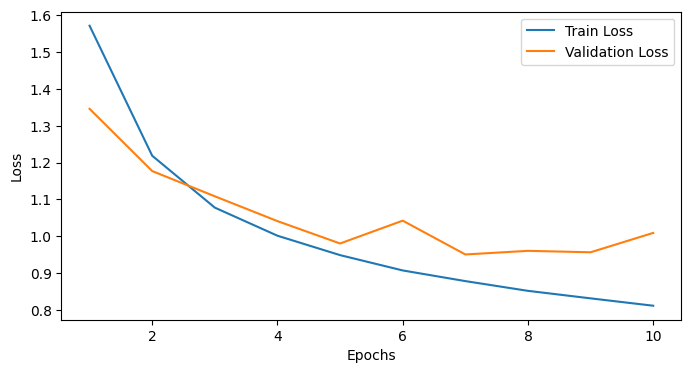

In [105]:
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 9: Evaluate the model

In [106]:
### Loading the pretrained model if exists
if os.path.exists('pretrained_model_2.ckpt'):
    model.load_state_dict(torch.load('pretrained_model_2.ckpt'))

In [107]:
# Evaluate the network on the validation set
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

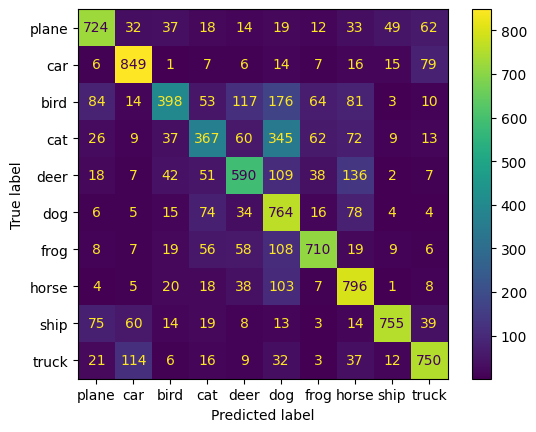

In [108]:
confusion_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, 
                              display_labels=classes)
disp.plot()
plt.show()

In [109]:
print(f'Accuracy_ {accuracy_np(y_pred, y_true)}')

Accuracy_ 0.6703


In [110]:
print('Recall per class:')
for i in range(len(classes)):
    print(f'{classes[i]}: {recall_np(y_pred, y_true, i)}')

Recall per class:
724 276
plane: 0.724
849 151
car: 0.849
398 602
bird: 0.398
367 633
cat: 0.367
590 410
deer: 0.59
764 236
dog: 0.764
710 290
frog: 0.71
796 204
horse: 0.796
755 245
ship: 0.755
750 250
truck: 0.75


In [111]:
print('Precision per class:')
for i in range(len(classes)):
    print(f'{classes[i]}: {precision_np(y_pred, y_true, i)}')

Precision per class:
plane: 0.7448559670781894
car: 0.7704174228675136
bird: 0.6757215619694398
cat: 0.540500736377025
deer: 0.6316916488222698
dog: 0.45395127748068925
frog: 0.7700650759219089
horse: 0.6209048361934477
ship: 0.8789289871944121
truck: 0.7668711656441718


## Answer the following questions

1. Analyze the plots (loss curves) in both models. What do they indicate? Discuss it in detail. (2 point)

First model's loss curve: 

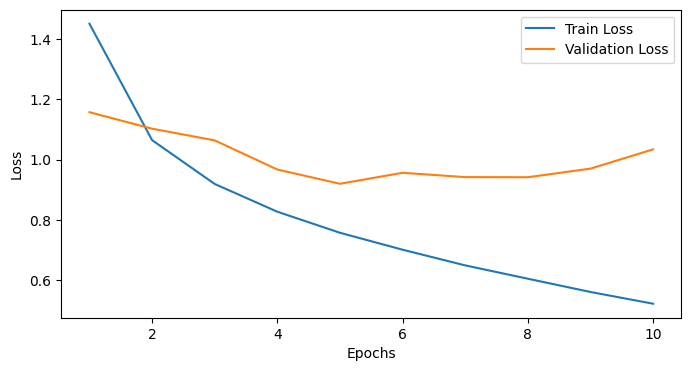

Second model's loss curve: 

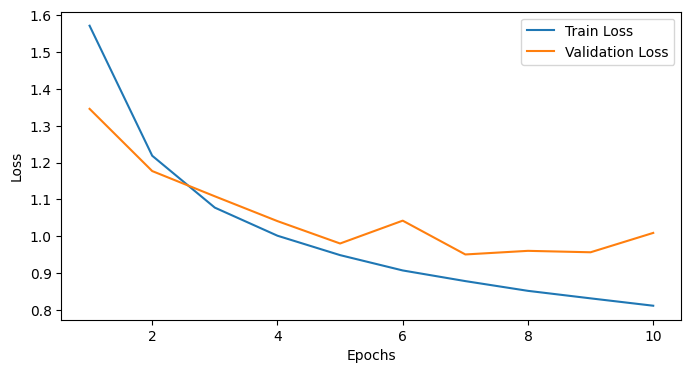

The train loss refers to the error computed on the training set during each iteration of the training process. It measures how well the model is fitting the training data. 
The validation loss does the same thing for the validation data.

In the first model, we can see that the train loss is decreasing and the validation loss is increasing, and deviate from each other. As usual a high variance means that the model is overfitting the training data which is an indication that it does not do as well on unseen data as with the training data.

In the second model this deviation decreases, meaning that the difference between the error in the validation set and the training set is smaller. This means that the model is not overfitting as much the training data and it is more likely to perform well on unseen data.
This makes sense as the second model was trained using augmented data, in particular:
- Adding more images: More images means more data for the model to learn from, which can improve generalization and reduce overfitting.
- RandomHorizontalFlip: Flipping images horizontally introduces variations and makes the model more indifferent to orientations.
- ColorJitter: Adjusting brightness, contrast, saturation, and hue introduces variations in color and lighting conditions, improving the model's ability to handle different illuminations.
- GaussianBlur: Applying Gaussian blur smoothes out noise and minor details, encouraging the model to focus on higher-level patterns and reducing sensitivity to small variations.

Because of this data augmentations the second model performs substantially better than the first one in terms of 

2. Analyze the confussion matrix in both models. What images are more problematic for the models? What images are easier ? Discuss it in detail. (2 points)

YOUR ANSWER HERE

3. Analize the metrics (accuracy, precision, and recall) of both models. Discuss the results in detail. (2 points)

YOUR ANSWER HERE

4. How can you improve the results of the models? (1 point)

YOUR ANSWER HERE